In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
# import transformers
# nltk.download('punkt')
# nltk.download('stopwords')
stop = stopwords.words('english')
import re
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing, metrics
from lime import lime_text
import gensim
import gensim.downloader as gensim_api
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K

In [2]:
all_wines = pd.read_csv('Data/winemag-data-130k-v2.csv')
all_wines.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [3]:
# Dropping unused variables
clean_wines = all_wines.drop(columns=['Unnamed: 0', 'taster_twitter_handle', 'region_2'])
clean_wines = clean_wines.dropna()
clean_wines.head()

,country,description,designation,points,price,province,region_1,taster_name,title,variety,winery
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,Alexander Peartree,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Paul Gregutt,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks
5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,Michael Schachner,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem
6,Italy,"Here's a bright, informal red that opens with ...",Belsito,87,16.0,Sicily & Sardinia,Vittoria,Kerin O’Keefe,Terre di Giurfo 2013 Belsito Frappato (Vittoria),Frappato,Terre di Giurfo
9,France,This has great depth of flavor with its fresh ...,Les Natures,87,27.0,Alsace,Alsace,Roger Voss,Jean-Baptiste Adam 2012 Les Natures Pinot Gris...,Pinot Gris,Jean-Baptiste Adam


In [4]:
# Fixing specific variety confusion in the dataset
clean_wines['variety'] = clean_wines['variety'].replace(['Weissburgunder'], 'Chardonnay')
clean_wines['variety'] = clean_wines['variety'].replace(['Spatburgunder'], 'Pinot Noir')
clean_wines['variety'] = clean_wines['variety'].replace(['Grauburgunder'], 'Pinot Gris')
clean_wines['variety'] = clean_wines['variety'].replace(['Garnacha'], 'Grenache')
clean_wines['variety'] = clean_wines['variety'].replace(['Pinot Nero'], 'Pinot Noir')
clean_wines['variety'] = clean_wines['variety'].replace(['Alvarinho'], 'Albarino')

In [5]:
clean_wines['vintage'] = clean_wines['title'].str.extract('(\d\d\d\d)', expand=True)
clean_wines

,country,description,designation,points,price,province,region_1,taster_name,title,variety,winery,vintage
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,Alexander Peartree,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,2013
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Paul Gregutt,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,2012
5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,Michael Schachner,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem,2011
6,Italy,"Here's a bright, informal red that opens with ...",Belsito,87,16.0,Sicily & Sardinia,Vittoria,Kerin O’Keefe,Terre di Giurfo 2013 Belsito Frappato (Vittoria),Frappato,Terre di Giurfo,2013
9,France,This has great depth of flavor with its fresh ...,Les Natures,87,27.0,Alsace,Alsace,Roger Voss,Jean-Baptiste Adam 2012 Les Natures Pinot Gris...,Pinot Gris,Jean-Baptiste Adam,2012
...,...,...,...,...,...,...,...,...,...,...,...,...
129959,France,The granite soil of the Brand Grand Cru vineya...,Brand Grand Cru,90,57.0,Alsace,Alsace,Roger Voss,Cave de Turckheim 2010 Brand Grand Cru Pinot G...,Pinot Gris,Cave de Turckheim,2010
129962,Italy,"Blackberry, cassis, grilled herb and toasted a...",Sàgana Tenuta San Giacomo,90,40.0,Sicily & Sardinia,Sicilia,Kerin O’Keefe,Cusumano 2012 Sàgana Tenuta San Giacomo Nero d...,Nero d'Avola,Cusumano,2012
129965,France,"While it's rich, this beautiful dry wine also ...",Seppi Landmann Vallée Noble,90,28.0,Alsace,Alsace,Roger Voss,Domaine Rieflé-Landmann 2013 Seppi Landmann Va...,Pinot Gris,Domaine Rieflé-Landmann,2013
129968,France,Well-drained gravel soil gives this wine its c...,Kritt,90,30.0,Alsace,Alsace,Roger Voss,Domaine Gresser 2013 Kritt Gewurztraminer (Als...,Gewürztraminer,Domaine Gresser,2013


In [6]:
# Designating red/white wine types based on variety
clean_wines['type'] = ['white' if x in ['Chardonnay', 'Riesling', 'Sauvignon Blanc', 'White Blend', 'Sparkling Blend', 'Pinot Gris',
                                        'Champagne Blend', 'GrÃ¼ner Veltliner', 'Pinot Grigio', 'Portuguese White', 'Viognier',
                                        'GewÃ¼rztraminer', 'GewÃ¼rztraminer'] else 'red' for x in clean_wines['variety']]
clean_wines

,country,description,designation,points,price,province,region_1,taster_name,title,variety,winery,vintage,type
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,Alexander Peartree,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,2013,white
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Paul Gregutt,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,2012,red
5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,Michael Schachner,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem,2011,red
6,Italy,"Here's a bright, informal red that opens with ...",Belsito,87,16.0,Sicily & Sardinia,Vittoria,Kerin O’Keefe,Terre di Giurfo 2013 Belsito Frappato (Vittoria),Frappato,Terre di Giurfo,2013,red
9,France,This has great depth of flavor with its fresh ...,Les Natures,87,27.0,Alsace,Alsace,Roger Voss,Jean-Baptiste Adam 2012 Les Natures Pinot Gris...,Pinot Gris,Jean-Baptiste Adam,2012,white
...,...,...,...,...,...,...,...,...,...,...,...,...,...
129959,France,The granite soil of the Brand Grand Cru vineya...,Brand Grand Cru,90,57.0,Alsace,Alsace,Roger Voss,Cave de Turckheim 2010 Brand Grand Cru Pinot G...,Pinot Gris,Cave de Turckheim,2010,white
129962,Italy,"Blackberry, cassis, grilled herb and toasted a...",Sàgana Tenuta San Giacomo,90,40.0,Sicily & Sardinia,Sicilia,Kerin O’Keefe,Cusumano 2012 Sàgana Tenuta San Giacomo Nero d...,Nero d'Avola,Cusumano,2012,red
129965,France,"While it's rich, this beautiful dry wine also ...",Seppi Landmann Vallée Noble,90,28.0,Alsace,Alsace,Roger Voss,Domaine Rieflé-Landmann 2013 Seppi Landmann Va...,Pinot Gris,Domaine Rieflé-Landmann,2013,white
129968,France,Well-drained gravel soil gives this wine its c...,Kritt,90,30.0,Alsace,Alsace,Roger Voss,Domaine Gresser 2013 Kritt Gewurztraminer (Als...,Gewürztraminer,Domaine Gresser,2013,red


In [7]:
clean_wines['word_count'] = clean_wines['description'].str.lower().str.split().str.len()
clean_wines

,country,description,designation,points,price,province,region_1,taster_name,title,variety,winery,vintage,type,word_count
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,Alexander Peartree,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,2013,white,33
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Paul Gregutt,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,2012,red,41
5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,Michael Schachner,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem,2011,red,42
6,Italy,"Here's a bright, informal red that opens with ...",Belsito,87,16.0,Sicily & Sardinia,Vittoria,Kerin O’Keefe,Terre di Giurfo 2013 Belsito Frappato (Vittoria),Frappato,Terre di Giurfo,2013,red,31
9,France,This has great depth of flavor with its fresh ...,Les Natures,87,27.0,Alsace,Alsace,Roger Voss,Jean-Baptiste Adam 2012 Les Natures Pinot Gris...,Pinot Gris,Jean-Baptiste Adam,2012,white,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129959,France,The granite soil of the Brand Grand Cru vineya...,Brand Grand Cru,90,57.0,Alsace,Alsace,Roger Voss,Cave de Turckheim 2010 Brand Grand Cru Pinot G...,Pinot Gris,Cave de Turckheim,2010,white,52
129962,Italy,"Blackberry, cassis, grilled herb and toasted a...",Sàgana Tenuta San Giacomo,90,40.0,Sicily & Sardinia,Sicilia,Kerin O’Keefe,Cusumano 2012 Sàgana Tenuta San Giacomo Nero d...,Nero d'Avola,Cusumano,2012,red,37
129965,France,"While it's rich, this beautiful dry wine also ...",Seppi Landmann Vallée Noble,90,28.0,Alsace,Alsace,Roger Voss,Domaine Rieflé-Landmann 2013 Seppi Landmann Va...,Pinot Gris,Domaine Rieflé-Landmann,2013,white,32
129968,France,Well-drained gravel soil gives this wine its c...,Kritt,90,30.0,Alsace,Alsace,Roger Voss,Domaine Gresser 2013 Kritt Gewurztraminer (Als...,Gewürztraminer,Domaine Gresser,2013,red,43


In [8]:
clean_wines = clean_wines[clean_wines['vintage'].notna()]
clean_wines = clean_wines.copy()
clean_wines['vintage'] = clean_wines['vintage'].astype(int)
clean_wines['age'] = 2021 - clean_wines['vintage'] 
clean_wines

,country,description,designation,points,price,province,region_1,taster_name,title,variety,winery,vintage,type,word_count,age
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,Alexander Peartree,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,2013,white,33,8
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Paul Gregutt,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,2012,red,41,9
5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,Michael Schachner,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem,2011,red,42,10
6,Italy,"Here's a bright, informal red that opens with ...",Belsito,87,16.0,Sicily & Sardinia,Vittoria,Kerin O’Keefe,Terre di Giurfo 2013 Belsito Frappato (Vittoria),Frappato,Terre di Giurfo,2013,red,31,8
9,France,This has great depth of flavor with its fresh ...,Les Natures,87,27.0,Alsace,Alsace,Roger Voss,Jean-Baptiste Adam 2012 Les Natures Pinot Gris...,Pinot Gris,Jean-Baptiste Adam,2012,white,30,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129959,France,The granite soil of the Brand Grand Cru vineya...,Brand Grand Cru,90,57.0,Alsace,Alsace,Roger Voss,Cave de Turckheim 2010 Brand Grand Cru Pinot G...,Pinot Gris,Cave de Turckheim,2010,white,52,11
129962,Italy,"Blackberry, cassis, grilled herb and toasted a...",Sàgana Tenuta San Giacomo,90,40.0,Sicily & Sardinia,Sicilia,Kerin O’Keefe,Cusumano 2012 Sàgana Tenuta San Giacomo Nero d...,Nero d'Avola,Cusumano,2012,red,37,9
129965,France,"While it's rich, this beautiful dry wine also ...",Seppi Landmann Vallée Noble,90,28.0,Alsace,Alsace,Roger Voss,Domaine Rieflé-Landmann 2013 Seppi Landmann Va...,Pinot Gris,Domaine Rieflé-Landmann,2013,white,32,8
129968,France,Well-drained gravel soil gives this wine its c...,Kritt,90,30.0,Alsace,Alsace,Roger Voss,Domaine Gresser 2013 Kritt Gewurztraminer (Als...,Gewürztraminer,Domaine Gresser,2013,red,43,8


In [9]:
clean_wines = clean_wines.drop_duplicates('description')
clean_wines = clean_wines[pd.notnull(clean_wines.price)]

In [10]:
clean_wines.quantile(q=0.75, axis=0, numeric_only=True)

points          91.0
price           49.0
vintage       2014.0
word_count      49.0
age             11.0
Name: 0.75, dtype: float64

<AxesSubplot:>

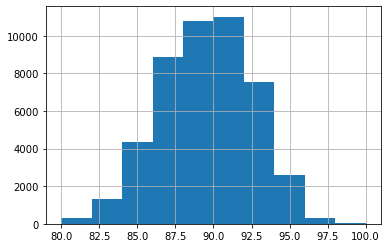

In [11]:
clean_wines['points'].hist()

In [12]:
# Creating binary good/bad designation for wines
clean_wines['good_bad'] = clean_wines['points'].apply(lambda x: 'good' if x >= 89 else 'bad')
clean_wines

,country,description,designation,points,price,province,region_1,taster_name,title,variety,winery,vintage,type,word_count,age,good_bad
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,Alexander Peartree,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,2013,white,33,8,bad
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Paul Gregutt,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,2012,red,41,9,bad
5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,Michael Schachner,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem,2011,red,42,10,bad
6,Italy,"Here's a bright, informal red that opens with ...",Belsito,87,16.0,Sicily & Sardinia,Vittoria,Kerin O’Keefe,Terre di Giurfo 2013 Belsito Frappato (Vittoria),Frappato,Terre di Giurfo,2013,red,31,8,bad
9,France,This has great depth of flavor with its fresh ...,Les Natures,87,27.0,Alsace,Alsace,Roger Voss,Jean-Baptiste Adam 2012 Les Natures Pinot Gris...,Pinot Gris,Jean-Baptiste Adam,2012,white,30,9,bad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129959,France,The granite soil of the Brand Grand Cru vineya...,Brand Grand Cru,90,57.0,Alsace,Alsace,Roger Voss,Cave de Turckheim 2010 Brand Grand Cru Pinot G...,Pinot Gris,Cave de Turckheim,2010,white,52,11,good
129962,Italy,"Blackberry, cassis, grilled herb and toasted a...",Sàgana Tenuta San Giacomo,90,40.0,Sicily & Sardinia,Sicilia,Kerin O’Keefe,Cusumano 2012 Sàgana Tenuta San Giacomo Nero d...,Nero d'Avola,Cusumano,2012,red,37,9,good
129965,France,"While it's rich, this beautiful dry wine also ...",Seppi Landmann Vallée Noble,90,28.0,Alsace,Alsace,Roger Voss,Domaine Rieflé-Landmann 2013 Seppi Landmann Va...,Pinot Gris,Domaine Rieflé-Landmann,2013,white,32,8,good
129968,France,Well-drained gravel soil gives this wine its c...,Kritt,90,30.0,Alsace,Alsace,Roger Voss,Domaine Gresser 2013 Kritt Gewurztraminer (Als...,Gewürztraminer,Domaine Gresser,2013,red,43,8,good


In [13]:
# Adding grades 
clean_wines['grade'] = clean_wines['points'].apply(lambda x: 'A' if x >= 92 else
                                                             'B' if x >= 89 else
                                                             'C' if x >= 86 else
                                                             'F')
clean_wines

,country,description,designation,points,price,province,region_1,taster_name,title,variety,winery,vintage,type,word_count,age,good_bad,grade
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,Alexander Peartree,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,2013,white,33,8,bad,C
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Paul Gregutt,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,2012,red,41,9,bad,C
5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,Michael Schachner,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem,2011,red,42,10,bad,C
6,Italy,"Here's a bright, informal red that opens with ...",Belsito,87,16.0,Sicily & Sardinia,Vittoria,Kerin O’Keefe,Terre di Giurfo 2013 Belsito Frappato (Vittoria),Frappato,Terre di Giurfo,2013,red,31,8,bad,C
9,France,This has great depth of flavor with its fresh ...,Les Natures,87,27.0,Alsace,Alsace,Roger Voss,Jean-Baptiste Adam 2012 Les Natures Pinot Gris...,Pinot Gris,Jean-Baptiste Adam,2012,white,30,9,bad,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129959,France,The granite soil of the Brand Grand Cru vineya...,Brand Grand Cru,90,57.0,Alsace,Alsace,Roger Voss,Cave de Turckheim 2010 Brand Grand Cru Pinot G...,Pinot Gris,Cave de Turckheim,2010,white,52,11,good,B
129962,Italy,"Blackberry, cassis, grilled herb and toasted a...",Sàgana Tenuta San Giacomo,90,40.0,Sicily & Sardinia,Sicilia,Kerin O’Keefe,Cusumano 2012 Sàgana Tenuta San Giacomo Nero d...,Nero d'Avola,Cusumano,2012,red,37,9,good,B
129965,France,"While it's rich, this beautiful dry wine also ...",Seppi Landmann Vallée Noble,90,28.0,Alsace,Alsace,Roger Voss,Domaine Rieflé-Landmann 2013 Seppi Landmann Va...,Pinot Gris,Domaine Rieflé-Landmann,2013,white,32,8,good,B
129968,France,Well-drained gravel soil gives this wine its c...,Kritt,90,30.0,Alsace,Alsace,Roger Voss,Domaine Gresser 2013 Kritt Gewurztraminer (Als...,Gewürztraminer,Domaine Gresser,2013,red,43,8,good,B


In [14]:
good_wines = clean_wines[clean_wines['good_bad'] == 'good']
good_wines

,country,description,designation,points,price,province,region_1,taster_name,title,variety,winery,vintage,type,word_count,age,good_bad,grade
123,Australia,The blend is roughly two-thirds Shiraz and one...,Parson's Flat,92,40.0,South Australia,Padthaway,Joe Czerwinski,Henry's Drive Vignerons 2006 Parson's Flat Shi...,Shiraz-Cabernet Sauvignon,Henry's Drive Vignerons,2006,red,36,15,good,A
144,US,"Thick and brooding, this dark, sweetly tannic ...",K Block,91,85.0,California,Spring Mountain District,Virginie Boone,Terra Valentine 2013 K Block Cabernet Sauvigno...,Cabernet Sauvignon,Terra Valentine,2013,red,37,8,good,B
145,US,"Cooked cranberry is spiced with anise, pepperc...",Guidotti Vineyard,91,64.0,California,Santa Lucia Highlands,Matt Kettmann,Testarossa 2013 Guidotti Vineyard Pinot Noir (...,Pinot Noir,Testarossa,2013,red,43,8,good,B
146,US,"There's a touch of hot asphalt, pencil lead an...",Family Reserve,91,68.0,California,Santa Ynez Valley,Matt Kettmann,Vincent Vineyards 2010 Family Reserve Cabernet...,Cabernet Sauvignon,Vincent Vineyards,2010,red,51,11,good,B
147,US,"Black cherry, black plum and black currant are...",Family Reserve,91,68.0,California,Santa Ynez Valley,Matt Kettmann,Vincent Vineyards 2012 Family Reserve Cabernet...,Cabernet Sauvignon,Vincent Vineyards,2012,red,55,9,good,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129959,France,The granite soil of the Brand Grand Cru vineya...,Brand Grand Cru,90,57.0,Alsace,Alsace,Roger Voss,Cave de Turckheim 2010 Brand Grand Cru Pinot G...,Pinot Gris,Cave de Turckheim,2010,white,52,11,good,B
129962,Italy,"Blackberry, cassis, grilled herb and toasted a...",Sàgana Tenuta San Giacomo,90,40.0,Sicily & Sardinia,Sicilia,Kerin O’Keefe,Cusumano 2012 Sàgana Tenuta San Giacomo Nero d...,Nero d'Avola,Cusumano,2012,red,37,9,good,B
129965,France,"While it's rich, this beautiful dry wine also ...",Seppi Landmann Vallée Noble,90,28.0,Alsace,Alsace,Roger Voss,Domaine Rieflé-Landmann 2013 Seppi Landmann Va...,Pinot Gris,Domaine Rieflé-Landmann,2013,white,32,8,good,B
129968,France,Well-drained gravel soil gives this wine its c...,Kritt,90,30.0,Alsace,Alsace,Roger Voss,Domaine Gresser 2013 Kritt Gewurztraminer (Als...,Gewürztraminer,Domaine Gresser,2013,red,43,8,good,B


In [15]:
# Adding quantitative features based on description 
clean_wines['char_count'] = clean_wines["description"].apply(lambda x: sum(len(word) for word in str(x).split(" ")))
clean_wines['sentence_count'] = clean_wines["description"].apply(lambda x: len(str(x).split(".")))
clean_wines['avg_word_length'] = clean_wines['char_count'] / clean_wines['word_count']
clean_wines['avg_sentence_lenght'] = clean_wines['word_count'] / clean_wines['sentence_count']
clean_wines

,country,description,designation,points,price,province,region_1,taster_name,title,variety,...,vintage,type,word_count,age,good_bad,grade,char_count,sentence_count,avg_word_length,avg_sentence_lenght
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,Alexander Peartree,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,...,2013,white,33,8,bad,C,167,3,5.060606,11.000000
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Paul Gregutt,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,...,2012,red,41,9,bad,C,209,3,5.097561,13.666667
5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,Michael Schachner,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,...,2011,red,42,10,bad,C,220,4,5.238095,10.500000
6,Italy,"Here's a bright, informal red that opens with ...",Belsito,87,16.0,Sicily & Sardinia,Vittoria,Kerin O’Keefe,Terre di Giurfo 2013 Belsito Frappato (Vittoria),Frappato,...,2013,red,31,8,bad,C,151,3,4.870968,10.333333
9,France,This has great depth of flavor with its fresh ...,Les Natures,87,27.0,Alsace,Alsace,Roger Voss,Jean-Baptiste Adam 2012 Les Natures Pinot Gris...,Pinot Gris,...,2012,white,30,9,bad,C,131,4,4.366667,7.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129959,France,The granite soil of the Brand Grand Cru vineya...,Brand Grand Cru,90,57.0,Alsace,Alsace,Roger Voss,Cave de Turckheim 2010 Brand Grand Cru Pinot G...,Pinot Gris,...,2010,white,52,11,good,B,237,5,4.557692,10.400000
129962,Italy,"Blackberry, cassis, grilled herb and toasted a...",Sàgana Tenuta San Giacomo,90,40.0,Sicily & Sardinia,Sicilia,Kerin O’Keefe,Cusumano 2012 Sàgana Tenuta San Giacomo Nero d...,Nero d'Avola,...,2012,red,37,9,good,B,184,4,4.972973,9.250000
129965,France,"While it's rich, this beautiful dry wine also ...",Seppi Landmann Vallée Noble,90,28.0,Alsace,Alsace,Roger Voss,Domaine Rieflé-Landmann 2013 Seppi Landmann Va...,Pinot Gris,...,2013,white,32,8,good,B,180,3,5.625000,10.666667
129968,France,Well-drained gravel soil gives this wine its c...,Kritt,90,30.0,Alsace,Alsace,Roger Voss,Domaine Gresser 2013 Kritt Gewurztraminer (Als...,Gewürztraminer,...,2013,red,43,8,good,B,183,4,4.255814,10.750000


In [16]:
# Adding features by counting wineries, countries, etc... and merging them back into clean_wines
winery_counts = {'winery' : clean_wines['winery'].unique(), 
                 'winery_count' : clean_wines['winery'].value_counts() 

            }
winery_df = pd.DataFrame(data=winery_counts)
winery_df.reset_index(drop=True, inplace=True)
winery_df

,winery,winery_count
0,St. Julian,144
1,Sweet Cheeks,117
2,Tandem,103
3,Terre di Giurfo,100
4,Jean-Baptiste Adam,90
...,...,...
8286,Yacochuya,1
8287,Tollot Beaut et Fils,1
8288,Bottega,1
8289,Bodegas Eidosela,1


In [17]:
clean_wines = clean_wines.merge(winery_df, how='inner', on='winery')
clean_wines.sample(30)

,country,description,designation,points,price,province,region_1,taster_name,title,variety,...,type,word_count,age,good_bad,grade,char_count,sentence_count,avg_word_length,avg_sentence_lenght,winery_count
34471,France,"For the modest tariff, this is really good. Ar...",Les Cerisiers,87,10.0,Rhône Valley,Côtes du Rhône,Joe Czerwinski,Boutinot 2016 Les Cerisiers Rosé (Côtes du Rhône),Rosé,...,red,30,5,bad,C,146,4,4.866667,7.500000,3
26024,Spain,"A dark tint and ripe aromas of blackberry, bla...",Roble,89,11.0,Northern Spain,Ribera del Duero,Michael Schachner,Tierras Guindas 2011 Roble (Ribera del Duero),Tempranillo,...,red,43,10,good,B,223,4,5.186047,10.750000,6
12854,US,"Named for brand co-founder Janie Master, this ...",Cuvee Jeane,86,12.0,California,Central Coast,Matt Kettmann,Tortoise Creek 2014 Cuvee Jeane Sauvignon Blan...,Sauvignon Blanc,...,white,45,7,bad,C,233,3,5.177778,15.000000,13
8805,Spain,Briny citrus and petrol aromas are unusual for...,Luzón Blanco,85,8.0,Levante,Jumilla,Michael Schachner,Bodegas Luzón 2014 Luzón Blanco Macabeo (Jumilla),Macabeo,...,red,26,7,bad,F,143,5,5.500000,5.200000,18
41814,France,"Bright, red berried wine from the charity-owne...",Clos Cristal,89,24.0,Loire Valley,Saumur-Champigny,Roger Voss,Hospices de Saumur 2009 Clos Cristal (Saumur-...,Cabernet Franc,...,red,27,12,good,B,147,3,5.444444,9.000000,2
30040,US,This big but smooth wine has a seductive spicy...,Estate Grown & Bottled,91,39.0,California,El Dorado,Jim Gordon,Di Arie 2011 Estate Grown & Bottled Cabernet S...,Cabernet Sauvignon,...,red,57,10,good,B,287,4,5.035088,14.250000,5
21234,France,"What to mention first? A hint of mossy earth, ...",Clos Saint Urbain Rangen de Thann Grand Cru,96,120.0,Alsace,Alsace,Anne Krebiehl MW,Domaine Zind-Humbrecht 2014 Clos Saint Urbain ...,Riesling,...,white,87,7,good,A,409,7,4.701149,12.428571,8
6048,US,"Grown primarily in Chile these days, Carmenère...",Rennie Vineyard,87,30.0,California,Yorkville Highlands,Virginie Boone,Yorkville Cellars 2009 Rennie Vineyard Carmenè...,Carmenère,...,red,28,12,bad,C,131,2,4.678571,14.000000,23
41189,Italy,"Showing surprising structure for the vintage, ...",Marine,90,40.0,Piedmont,Colli Tortonesi,Kerin O’Keefe,Vigne Marina Coppi 2014 Marine Favorita (Colli...,Favorita,...,red,32,7,good,B,182,3,5.687500,10.666667,2
3760,Argentina,Plum and raspberry aromas are wiry in nature a...,Barrel Selection,90,50.0,Mendoza Province,Mendoza,Michael Schachner,Proemio 2009 Barrel Selection Red (Mendoza),Red Blend,...,red,46,12,good,B,243,5,5.282609,9.200000,29


In [18]:
country_counts = {'country' : clean_wines['country'].unique(),
             'country_count' : clean_wines['country'].value_counts()
            }
country_df = pd.DataFrame(data=country_counts)
country_df.reset_index(drop=True, inplace=True)
country_df

,country,country_count
0,US,23237
1,Spain,9408
2,Italy,6120
3,France,4337
4,Argentina,2579
5,Australia,1309
6,Canada,154


In [19]:
clean_wines = clean_wines.merge(country_df, how='inner', on='country')
clean_wines.sample(30)

,country,description,designation,points,price,province,region_1,taster_name,title,variety,...,word_count,age,good_bad,grade,char_count,sentence_count,avg_word_length,avg_sentence_lenght,winery_count,country_count
5566,US,This extroverted and very yummy wine is dark a...,Winemaker's Blend Reserve,90,14.0,California,California,Jim Gordon,Red Rock 2012 Winemaker's Blend Reserve Red (C...,Red Blend,...,45,9,good,B,220,5,4.888889,9.000000,16,23237
21982,US,A mix of just-ripe fruit flavors and savory ac...,North Coast,88,20.0,California,North Coast,Jim Gordon,Chime 2014 North Coast Pinot Noir (North Coast),Pinot Noir,...,37,7,bad,C,179,3,4.837838,12.333333,1,23237
43149,Argentina,Brushy aromas of wild herbs along with cherry ...,Reserva,87,13.0,Mendoza Province,Mendoza,Michael Schachner,Kaiken 2012 Reserva Malbec (Mendoza),Malbec,...,47,9,bad,C,220,4,4.680851,11.750000,40,2579
27855,Italy,"This opens with aromas suggesting toasted nut,...",Satén,88,54.0,Lombardy,Franciacorta,Kerin O’Keefe,Bellavista 2011 Satén Chardonnay (Franciacorta),Chardonnay,...,35,10,bad,C,186,4,5.314286,8.750000,34,6120
10787,US,"Juicy, soft and sublime, this vineyard site si...",Campbell Ranch Vineyard,92,54.0,California,Sonoma Coast,Virginie Boone,Gros Ventre 2012 Campbell Ranch Vineyard Pinot...,Pinot Noir,...,42,9,good,A,233,3,5.547619,14.000000,9,23237
12306,US,"Nicole's is a consistent stunner, upholding it...",Nicole's Vineyard,93,65.0,California,Russian River Valley,Virginie Boone,J Vineyards & Winery 2012 Nicole's Vineyard Pi...,Pinot Noir,...,43,9,good,A,210,3,4.883721,14.333333,8,23237
38153,France,The golden hue promises flavors of development...,Comtes d'Eguisheim,93,66.0,Alsace,Alsace,Anne Krebiehl MW,Leon Beyer 2008 Comtes d'Eguisheim Pinot Gris ...,Pinot Gris,...,60,13,good,A,323,5,5.383333,12.000000,6,4337
7934,US,"Seriously refreshing, this pink and copper-col...",Dry,91,30.0,California,Livermore Valley,Jim Gordon,Murrieta's Well 2016 Dry Rosé (Livermore Valley),Rosé,...,47,5,good,B,261,3,5.553191,15.666667,12,23237
8001,US,This Oregon winery sources fruit for its Propr...,Proprietary Red,92,50.0,Washington,Columbia Valley (WA),Paul Gregutt,Pamplin 2008 Proprietary Red Red (Columbia Val...,Bordeaux-style Red Blend,...,55,13,good,A,292,3,5.309091,18.333333,12,23237
31583,Italy,Made with 90% Sangiovese and 10% Cabernet Sauv...,Palazza Riserva,88,27.0,Central Italy,Romagna,Kerin O’Keefe,Drei Donà 2013 Palazza Riserva Red (Romagna),Red Blend,...,32,8,bad,C,177,4,5.531250,8.000000,3,6120


In [20]:
province_counts = {'province' : clean_wines['province'].unique(),
             'province_count' : clean_wines['province'].value_counts()
            }
province_df = pd.DataFrame(data=province_counts)
province_df.reset_index(drop=True, inplace=True)
province_df

,province,province_count
0,Michigan,12491
1,Oregon,5325
2,California,3423
3,Washington,2770
4,Virginia,2209
5,New York,1928
6,Idaho,1824
7,Texas,1574
8,Pennsylvania,1462
9,New Jersey,1383


In [21]:
clean_wines = clean_wines.merge(province_df, how='inner', on='province')
clean_wines.sample(30)

,country,description,designation,points,price,province,region_1,taster_name,title,variety,...,age,good_bad,grade,char_count,sentence_count,avg_word_length,avg_sentence_lenght,winery_count,country_count,province_count
16745,US,Emmy is 70% Mourvèdre and 30% Syrah blend. The...,Emmy,92,36.0,Washington,Wahluke Slope,Paul Gregutt,Efeste 2008 Emmy Red (Wahluke Slope),Rhône-style Red Blend,...,13,good,A,300,4,4.477612,16.750000,25,23237,2770
8966,US,The grapes for this lovely wine come from the ...,Cuvée Renee,92,31.0,California,Sonoma County,Virginie Boone,Eric Kent 2014 Cuvée Renee Sauvignon Blanc (So...,Sauvignon Blanc,...,7,good,A,240,3,5.106383,15.666667,9,23237,3423
14163,US,"Thanks to wines like this, expect a bright fut...",Dijon Clone,89,32.0,California,Arroyo Seco,Matt Kettmann,Scott Family 2013 Dijon Clone Pinot Noir (Arro...,Pinot Noir,...,8,good,B,256,3,4.923077,17.333333,2,23237,3423
8274,US,The new oak is dialed down a bit to 33% in thi...,Monastery,95,70.0,California,Russian River Valley,Virginie Boone,Lynmar 2014 Monastery Pinot Noir (Russian Rive...,Pinot Noir,...,7,good,A,249,3,4.527273,18.333333,9,23237,3423
6883,US,Earthy forest floor and Asian spice ride atop ...,Stephanie's Cuvée,90,25.0,California,Green Valley,Virginie Boone,River Road 2014 Stephanie's Cuvée Pinot Noir (...,Pinot Noir,...,7,good,B,201,3,4.785714,14.000000,13,23237,3423
28525,Italy,"Aromas of scorched soil, truffle, ripe black-s...",Ilatraia,92,60.0,Tuscany,Toscana,Kerin O’Keefe,Brancaia 2011 Ilatraia Red (Toscana),Red Blend,...,10,good,A,297,4,5.823529,12.750000,9,6120,254
4224,US,Tobacco and cedar aromas add complexity to thi...,Silvaspoons Vineyard,87,22.0,California,Lodi,Jim Gordon,Fenestra 2012 Silvaspoons Vineyard Malbec (Lodi),Malbec,...,9,bad,C,116,2,5.272727,11.000000,33,23237,3423
13172,US,A stunning bottling from the Franscioni family...,Sierra Mar Vineyard,95,52.0,California,Santa Lucia Highlands,Matt Kettmann,Roar 2014 Sierra Mar Vineyard Pinot Noir (Sant...,Pinot Noir,...,7,good,A,301,4,5.679245,13.250000,3,23237,3423
40369,France,"Partly wood aged, this wine is conceived as th...",Prestige du,91,18.0,Southwest France,Cahors,Roger Voss,Château Lamartine 2014 Prestige du Malbec (Cah...,Malbec,...,7,good,B,215,5,4.886364,8.800000,2,4337,17
28636,Italy,"Aromas of mature black fruit, leather, vanilla...",Quercione Riserva,87,55.0,Tuscany,Vino Nobile di Montepulciano,Kerin O’Keefe,Lunadoro 2006 Quercione Riserva (Vino Nobile ...,Red Blend,...,15,bad,C,147,3,5.250000,9.333333,6,6120,254


In [22]:
region_counts = {'region_1' : clean_wines['region_1'].unique(),
             'region_count' : clean_wines['region_1'].value_counts()
            }
region_df = pd.DataFrame(data=region_counts)
region_df.reset_index(drop=True, inplace=True)
region_df

,region_1,region_count
0,Lake Michigan Shore,2240
1,Michigan,1509
2,Old Mission Peninsula,1483
3,Leelanau Peninsula,1344
4,Willamette Valley,1178
...,...,...
982,Short Hills Bench,1
983,St. David's Bench,1
984,Prince Edward County,1
985,Okanagan Valley,1


In [23]:
clean_wines = clean_wines.merge(region_df, how='inner', on='region_1')
clean_wines.sample(30)

,country,description,designation,points,price,province,region_1,taster_name,title,variety,...,good_bad,grade,char_count,sentence_count,avg_word_length,avg_sentence_lenght,winery_count,country_count,province_count,region_count
31659,Italy,"Forest floor, new leather, menthol and wild be...",Margheria,94,96.0,Piedmont,Barolo,Kerin O’Keefe,Massolino 2012 Margheria (Barolo),Nebbiolo,...,good,A,282,6,5.529412,8.500000,9,6120,154,9
8333,US,Age has mellowed this potent Port-style wine a...,Legacy 1868,87,45.0,California,California,Jim Gordon,Jessie's Grove 2001 Legacy 1868 Red (California),Red Blend,...,bad,C,208,4,4.837209,10.750000,3,23237,3423,301
43918,Argentina,"Savory, spicy, minty aromas are rustic and roo...",Tolentino Winemaker's Selection,86,15.0,Mendoza Province,Mendoza,Michael Schachner,Bodega Cuarto Dominio 2012 Tolentino Winemaker...,Malbec,...,bad,C,175,4,4.729730,9.250000,8,2579,9,1
9542,US,This dessert blend of 56% Sémillon and 44% Sau...,Grazia Late Harvest,89,39.0,California,Santa Ynez Valley,Matt Kettmann,Svago Buono 2012 Grazia Late Harvest White (Sa...,White Blend,...,good,B,239,3,5.195652,15.333333,3,23237,3423,276
19694,US,"An inaugural release, this wine displays aroma...",Cinghiale Wahluke Slope and Rosebud Vineyards,92,20.0,Washington,Wahluke Slope,Sean P. Sullivan,Casa Smith 2014 Cinghiale Wahluke Slope and Ro...,Sangiovese,...,good,A,200,4,5.128205,9.750000,5,23237,2770,48
26226,Spain,A sappy wild-berry aroma turns mulchy with air...,Crianza,81,15.0,Central Spain,La Mancha,Michael Schachner,Finca Antigua 2008 Crianza Red (La Mancha),Red Blend,...,bad,F,151,3,5.392857,9.333333,2,9408,415,31
5494,US,Made from grapes grown on the Olivet Lane Vine...,Orange Label,87,59.0,California,Russian River Valley,Virginie Boone,Roadhouse Winery 2014 Orange Label Pinot Noir ...,Pinot Noir,...,bad,C,149,2,5.321429,14.000000,4,23237,3423,415
42545,France,The top rosé cuvée from Léoube is full and ric...,Secret de Léoube,90,27.0,Provence,Côtes de Provence,Roger Voss,Château Léoube 2012 Secret de Léoube Rosé (Côt...,Rosé,...,good,B,149,4,4.382353,8.500000,8,4337,9,1
29808,Italy,"Made with organically farmed fruit, this richl...",Riserva,91,45.0,Tuscany,Vino Nobile di Montepulciano,Kerin O’Keefe,Il Conventino 2010 Riserva (Vino Nobile di Mo...,Red Blend,...,good,B,237,3,5.642857,14.000000,1,6120,254,18
5254,US,"From one of the producer's coolest sites, this...",Banfield Vineyards,94,60.0,California,Russian River Valley,Virginie Boone,Arista 2013 Banfield Vineyards Chardonnay (Rus...,Chardonnay,...,good,A,219,4,4.469388,12.250000,8,23237,3423,415


In [24]:
taster_counts = {'taster_name' : clean_wines['taster_name'].unique(),
             'taster_count' : clean_wines['taster_name'].value_counts()
            }
taster_df = pd.DataFrame(data=taster_counts)
taster_df.reset_index(drop=True, inplace=True)
taster_df

,taster_name,taster_count
0,Alexander Peartree,7433
1,Anna Lee C. Iijima,7022
2,Susan Kostrzewa,6065
3,Paul Gregutt,5978
4,Michael Schachner,5915
5,Joe Czerwinski,4068
6,Sean P. Sullivan,3013
7,Virginie Boone,2261
8,Jim Gordon,2119
9,Matt Kettmann,1490


In [25]:
clean_wines = clean_wines.merge(taster_df, how='inner', on='taster_name')
clean_wines.sample(30)

,country,description,designation,points,price,province,region_1,taster_name,title,variety,...,grade,char_count,sentence_count,avg_word_length,avg_sentence_lenght,winery_count,country_count,province_count,region_count,taster_count
35660,France,"Herbaceous and aromatic, this is a crisp, gree...",Cuvée Collection Prestige,85,22.0,Bordeaux,Graves,Roger Voss,Château du Barrailh 2010 Cuvée Collection Pres...,Bordeaux-style White Blend,...,F,145,4,5.800000,6.250000,1,4337,41,3,927
13107,Argentina,"Dark, sweet and rooty on the nose, with a warm...",Punto Final Reserva,89,20.0,Mendoza Province,Mendoza,Michael Schachner,Bodega Renacer 2007 Punto Final Reserva Malbec...,Malbec,...,B,193,4,4.595238,10.500000,7,2579,9,1,5915
15223,France,Marrenon's luxury cuvée aged in oak is 90% Gre...,Orca,87,19.0,Rhône Valley,Ventoux,Joe Czerwinski,Marrenon 2008 Orca Red (Ventoux),Rhône-style Red Blend,...,C,204,4,4.857143,10.500000,11,4337,53,5,4068
28849,US,"This blend of Petite Sirah, Syrah, Grenache an...",Heritage,88,27.0,California,Paso Robles,Matt Kettmann,San Antonio 2011 Heritage Red (Paso Robles),Rhône-style Red Blend,...,C,224,3,5.600000,13.333333,4,23237,3423,344,1490
1531,US,"A true field blend of Muscat, Pinot Grigio and...",Sylvanus,90,24.0,New York,"The Hamptons, Long Island",Anna Lee C. Iijima,Channing Daughters 2010 Sylvanus White (The Ha...,White Blend,...,B,305,4,4.841270,15.750000,4,23237,1928,43,7022
24516,US,"Terre Rouge's Ascent is, as intended, indeed i...",Ascent,93,85.0,California,Sierra Foothills,Virginie Boone,Terre Rouge 2010 Ascent Syrah (Sierra Foothills),Syrah,...,A,320,4,5.079365,15.750000,30,23237,3423,153,2261
8461,Spain,Compelling aromas of dry herbs blend with ripe...,Pagos de Viña Real,93,110.0,Northern Spain,Rioja,Michael Schachner,CVNE 2012 Pagos de Viña Real (Rioja),Tempranillo,...,A,254,5,5.183673,9.800000,8,9408,531,36,5915
29331,US,"Pale pink in color, this primarily Grenache- a...",Pale Pink,89,25.0,California,Santa Barbara County,Matt Kettmann,Municipal Winemakers 2016 Pale Pink Rosé (Sant...,Rosé,...,B,216,3,5.268293,13.666667,4,23237,3423,330,1490
47084,France,Faint notes of lemon zest and apple make for a...,Kirchberg de Barr Grand Cru,92,22.0,Alsace,Alsace,Anne Krebiehl MW,Klipfel 2014 Kirchberg de Barr Grand Cru Riesl...,Riesling,...,A,220,4,4.489796,12.250000,2,4337,57,5,8
26352,US,The extreme side of the grape variety comes ou...,Les Pionniers,88,45.0,California,California,Jim Gordon,Captûre 2014 Les Pionniers Sauvignon Blanc (Ca...,Sauvignon Blanc,...,C,179,2,5.114286,17.500000,2,23237,3423,301,2119


In [26]:
# LabelEncoder dependency
from sklearn.preprocessing import LabelEncoder

# create features
number = LabelEncoder()
features = clean_wines[['grade', 'good_bad', 'country','price','province','variety','winery','vintage', 'char_count', \
                        'sentence_count', 'avg_word_length', 'avg_sentence_lenght', 'winery_count', 'country_count', \
                        'province_count', 'region_count', 'taster_count']]
features['country'] = number.fit_transform(features['country'].astype('str'))
features['province'] = number.fit_transform(features['province'].astype('str'))
features['variety'] = number.fit_transform(features['variety'].astype('str'))
features['winery'] = number.fit_transform(features['winery'].astype('str'))

# features 
features.sample(10)

C:\Users\audri\anaconda3\envs\PythonAdv\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\audri\anaconda3\envs\PythonAdv\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\audri\anaconda3\envs\PythonAdv\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

,grade,good_bad,country,price,province,variety,winery,vintage,char_count,sentence_count,avg_word_length,avg_sentence_lenght,winery_count,country_count,province_count,region_count,taster_count
2653,B,good,6,45.0,38,269,323,2006,338,4,4.898551,17.250000,8,23237,5325,1178,5978
19201,B,good,6,40.0,57,69,7681,2014,217,3,5.292683,13.666667,7,23237,2770,48,3013
13726,C,bad,0,37.0,25,24,2685,2010,166,3,5.187500,10.666667,1,2579,9,1,5915
44314,A,good,4,40.0,41,233,3840,2010,233,5,5.177778,9.000000,6,6120,154,9,84
3836,B,good,6,40.0,38,69,1596,2011,153,3,4.935484,10.333333,34,23237,5325,713,5978
6877,A,good,6,55.0,57,288,3740,2009,281,4,5.301887,13.250000,7,23237,2770,49,5978
33102,A,good,3,60.0,7,69,4475,2005,198,4,4.604651,10.750000,3,4337,48,5,927
7211,B,good,6,23.0,57,307,266,1999,226,4,5.380952,10.500000,11,23237,2770,48,5978
29740,A,good,6,42.0,8,269,6293,2015,231,3,5.372093,14.333333,20,23237,3423,281,1490
42316,A,good,4,170.0,52,286,1064,2010,364,5,5.126761,14.200000,2,6120,254,18,84


In [27]:
features.to_csv('Data/all_features.csv')

In [28]:
# Can be run with or without price as a feature
# X = features.drop(columns=['grade', 'good_bad'])
X = features.drop(columns=['grade', 'good_bad', 'price'])
y = features['good_bad']

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras.utils import to_categorical

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
X_scaler = MinMaxScaler().fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)


# Step 1: Label-encode data set
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
encoded_y_train = label_encoder.transform(y_train)
encoded_y_test = label_encoder.transform(y_test)

# Step 2: Convert encoded labels to one-hot-encoding
y_train_categorical = to_categorical(encoded_y_train)
y_test_categorical = to_categorical(encoded_y_test)

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Dense(units=200, activation='relu', input_dim=14)) # remember to change input_dim if price included
model.add(Dense(units=200, activation='relu'))
model.add(Dense(units=2, activation='softmax'))

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               3000      
_________________________________________________________________
dense_1 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 402       
Total params: 43,602
Trainable params: 43,602
Non-trainable params: 0
_________________________________________________________________


In [32]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(
    X_train_scaled,
    y_train_categorical,
    epochs=60,
    shuffle=True,
    verbose=0
)

In [33]:
model_loss, model_accuracy = model.evaluate(
    X_test_scaled, y_test_categorical, verbose=2)
print(
    f"Normal Neural Network - Loss: {model_loss}, Accuracy: {model_accuracy}")

11786/11786 - 1s - loss: 0.5122 - accuracy: 0.7493
Normal Neural Network - Loss: 0.5122347459836786, Accuracy: 0.7492787837982178


In [34]:
encoded_predictions = model.predict_classes(X_test_scaled[:])
prediction_labels = label_encoder.inverse_transform(encoded_predictions)

In [35]:
d = {'prediction' : prediction_labels, 
     'actual' : y_test}

In [36]:
predictions_df = pd.DataFrame(data=d)
predictions_df.sample(30)

,prediction,actual
20089,good,bad
21220,good,good
13753,bad,bad
41354,good,good
24514,good,bad
43471,good,good
16563,good,good
36816,good,good
5493,bad,bad
38346,good,bad


In [37]:
# Remember to change depending on running with or without price as a feature
# predictions_df.to_csv('Data/predictions_all_features_binary.csv')
predictions_df.to_csv('Data/predictions_all_features_binary_no_price.csv')

In [38]:
# can be run with or without price
# X = features.drop(columns=['grade', 'good_bad'])
X = features.drop(columns=['grade', 'good_bad', 'price'])
y = features['grade']

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras.utils import to_categorical

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
X_scaler = MinMaxScaler().fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)


# Step 1: Label-encode data set
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
encoded_y_train = label_encoder.transform(y_train)
encoded_y_test = label_encoder.transform(y_test)

# Step 2: Convert encoded labels to one-hot-encoding
y_train_categorical = to_categorical(encoded_y_train)
y_test_categorical = to_categorical(encoded_y_test)

In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Dense(units=200, activation='relu', input_dim=14)) # remember to change input_dim if price included
model.add(Dense(units=200, activation='relu'))
model.add(Dense(units=4, activation='softmax'))

In [41]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 200)               3000      
_________________________________________________________________
dense_4 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 804       
Total params: 44,004
Trainable params: 44,004
Non-trainable params: 0
_________________________________________________________________


In [42]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(
    X_train_scaled,
    y_train_categorical,
    epochs=60,
    shuffle=True,
    verbose=0
)

In [43]:
model_loss, model_accuracy = model.evaluate(
    X_test_scaled, y_test_categorical, verbose=2)
print(
    f"Normal Neural Network - Loss: {model_loss}, Accuracy: {model_accuracy}")

11786/11786 - 1s - loss: 1.0533 - accuracy: 0.5098
Normal Neural Network - Loss: 1.053285461379983, Accuracy: 0.5097573399543762


In [44]:
encoded_predictions = model.predict_classes(X_test_scaled[:])
prediction_labels = label_encoder.inverse_transform(encoded_predictions)

In [45]:
d = {'prediction' : prediction_labels, 
     'actual' : y_test}

In [46]:
predictions_df = pd.DataFrame(data=d)
predictions_df.sample(30)

,prediction,actual
44170,A,A
26676,B,C
44295,B,A
32729,C,B
32259,C,C
22387,B,C
29536,B,A
16288,C,B
11953,C,C
21017,B,B


In [47]:
# Remember to change if price is included 
# predictions_df.to_csv('Data/predictions_all_features_grade.csv')
predictions_df.to_csv('Data/predictions_all_features_grade_no_price.csv')